In [1]:
!git clone https://github.com/robertocotesta/neural_covariance.git

Cloning into 'neural_covariance'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 42 (delta 8), reused 8 (delta 0), pack-reused 0
Unpacking objects: 100% (42/42), 7.27 MiB | 3.04 MiB/s, done.


In [3]:
import pickle
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch import nn
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

## Data wrangling

In [4]:
param_list = ['Mc', 'eta', 'DL', 'tc', 'phic', 'iota', 'ra', 'dec', 'psi']

In [5]:
def recreate_symmetric_matrix(size_X,X_flatten):
    X = np.zeros((size_X,size_X))
    X[np.triu_indices(X.shape[0], k = 0)] = X_flatten
    X = X + X.T - np.diag(np.diag(X))
    return X

def flatten_symmetric_matrix(X):
    return X[np.triu_indices(X.shape[0], k = 0)]

In [6]:
with open('/content/neural_covariance/Data/input.pkl','rb') as f:
    input_dataset = pickle.load(f)
with open('/content/neural_covariance/Data/output.pkl','rb') as f:
    output_dataset = pickle.load(f)    
with open('/content/neural_covariance/Data/SNRs.pkl','rb') as f:
    SNR_dataset = pickle.load(f)      

In [7]:
input_df = pd.DataFrame.from_dict(input_dataset, orient='index',columns=param_list)
# Only select columns that actually change
input_df = input_df[['Mc', 'eta', 'DL', 'iota', 'ra', 'dec']]

In [8]:
# Each matrix is symmetric, hence I only extract and flatten its triangular upper part
output_df = pd.DataFrame(data=[flatten_symmetric_matrix(output_dataset[i]) for i in output_dataset.keys()])

In [9]:
# Load SNR for interpolation
SNR_df = pd.DataFrame(data=SNR_dataset)

In [10]:
# Split test, train, CV for Fisher
# X_train, X_test, y_train, y_test = train_test_split(scaled_input_df,output_df.values,test_size=0.4,random_state=0)
# X_CV, X_test, y_CV, y_test = train_test_split(X_test,y_test,test_size=0.5,random_state=0)

In [11]:
# Split test, train, CV for SNR
X_train, X_test, y_train, y_test = train_test_split(input_df.values,SNR_df.values,test_size=0.4,random_state=0)
X_CV, X_test, y_CV, y_test = train_test_split(X_test,y_test,test_size=0.5,random_state=0)

In [12]:
# i_max = 2000
# X_train, y_train = X_train[:i_max], y_train[:i_max]

In [13]:
# sc_Input = StandardScaler()
# sc_Output = StandardScaler()
# input_df = input_df[['Mc', 'eta', 'DL', 'iota', 'ra', 'dec']]
# # Scaling input
# scaled_input_df = sc_Input.fit_transform(input_df)
# # Scaling output
# scaled_output_df = sc_Output.fit_transform(output_df)

## Build interpolant

In [14]:
# Definition of the device for training
device = "cuda" if torch.cuda.is_available() else "cpu"

In [24]:
# General settings for the training
epochs = 100000
lr = 0.001
batch_size  = y_train.shape[0]
input_layer_dim = X_train.shape[1]
output_layer_dim = y_train.shape[1]

In [16]:
# Definition of the neural network
class interpolant(nn.Module):
    def __init__(self,dim_input,dim_output):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(dim_input, 16),
            nn.ReLU(),
            nn.Linear(16, dim_output),
        )
        
    def forward(self,X):
        return self.linear_relu_stack(X)

In [17]:
model = interpolant(input_layer_dim,output_layer_dim).to(device)

In [18]:
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_CV = torch.from_numpy(X_CV).float()
y_CV = torch.from_numpy(y_CV).float()

In [19]:
X_train_mean = X_train.mean(axis=0)
X_train_std = X_train.std(axis=0)
y_train_mean = y_train.mean(axis=0)
y_train_std = y_train.std(axis=0)

X_train_normalized = (X_train-X_train_mean)/X_train_std
X_CV_normalized = (X_CV-X_train_mean)/X_train_std
y_train_normalized = (y_train-y_train_mean)/y_train_std
y_CV_normalized = (y_CV - y_train_mean)/y_train_std

In [20]:
def train_loop(dataloader, model, loss_fn, optimizer):
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_array.append(loss.item())

    return loss_array

In [21]:
# def train_loop(dataloader, model, loss_fn, optimizer):
#     loss_array = []
#     size = len(dataloader.dataset)
#     for batch, (X, y) in enumerate(dataloader):
#         X = X.to(device)
#         y = y.to(device)
#         # Compute prediction and loss
#         pred = model(X)
#         loss = loss_fn(pred, y)

#         # Backpropagation
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         loss_array.append(loss.item())

#     return loss_array

        # if batch % 100 == 0:
        #     loss, current = loss.item(), batch * len(X)
        #     print(f"loss: {loss:.2E}  [{current:>5d}/{size:>5d}]")


# def test_loop(dataloader, model, loss_fn):
#     size = len(dataloader.dataset)
#     num_batches = len(dataloader)
#     test_loss, correct = 0, 0

#     with torch.no_grad():
#         for X, y in dataloader:
#             X = X.to(device)
#             y = y.to(device)
#             pred = model(X)
#             test_loss += loss_fn(pred, y).item()

#     test_loss /= num_batches
#     print(f"Avg loss: {test_loss:>8f} \n")

In [25]:
# Definition of loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=lr)
loss_array = []
X = X_train_normalized.to(device)
y = y_train.to(device)
# Training loop
for t in tqdm(range(epochs)):
    #print(f"Epoch {t+1}\n-------------------------------")
    # Compute prediction and loss
    pred = model(X)
    loss = loss_fn(pred, y)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_array.append(loss.item())
print("Done!")

100%|██████████| 100000/100000 [02:06<00:00, 792.36it/s]

Done!


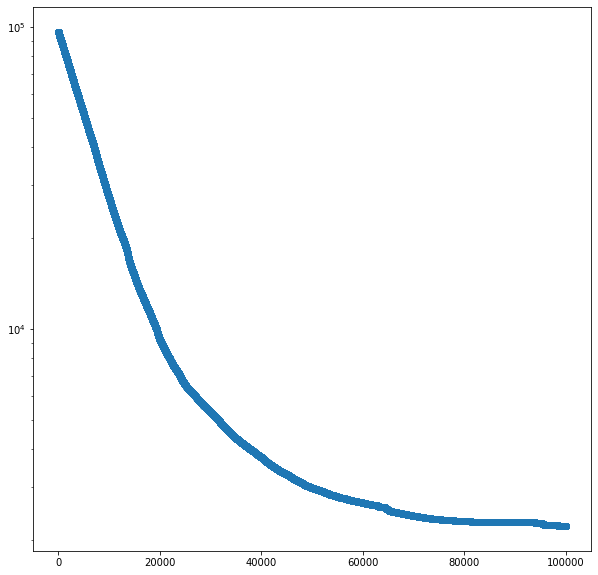

In [26]:
plt.figure(figsize=(10,10))
plt.scatter(np.arange(epochs),loss_array)
plt.yscale('log')

In [29]:
model(X_CV_normalized)

tensor([[1916.1749],
        [ 344.6519],
        [  68.7115],
        ...,
        [  14.9179],
        [  47.2112],
        [1168.2235]], grad_fn=<AddmmBackward0>)

In [30]:
y_CV

tensor([[2036.0526],
        [ 278.7384],
        [  40.8894],
        ...,
        [  13.5583],
        [  48.1667],
        [1253.8661]])